# Data Exploration and Temporal Analysis

## Libraries and Configurations

Import configuration files

In [120]:
from configparser import ConfigParser
import os

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [121]:
import pandas as pd

Import **other libraries**

In [122]:
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x109501690>>

Custom helper scripts

In [123]:
%cd ..
from scripts import plotHelper, timeHelper
%cd data_exploration_cleaning

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/data_exploration_cleaning


/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Data

In [124]:
# Combined dataframe raw
combined_df_csv = config["DEFAULT"]["interim_path"] + "combined_df_balanced_encoded.csv"

In [125]:
combined_df = pd.read_csv(combined_df_csv, index_col=0)

Fixing columns data types

In [126]:
combined_df.dtypes

Timestamp                    object
MAC Address                  object
Channel                       int64
DS Channel                  float64
HT Capabilities               int64
Extended Capabilities         int64
Vendor Specific Tags          int64
SSID                         object
Supported Rates               int64
Extended Supported Rates      int64
VHT Capabilities              int64
HE Capabilities               int64
Length                        int64
Label                        object
dtype: object

In [127]:
# Converting Timestamp to datetime
combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])

# Converting Label to string
combined_df["Label"] = combined_df["Label"].astype(str)

# Converting SSID to string
combined_df["SSID"] = combined_df["SSID"].astype(str)

# Converting MAC Address to string
combined_df["MAC Address"] = combined_df["MAC Address"].astype(str)

# Converting HT Capabilities to string
combined_df["HT Capabilities"] = combined_df["HT Capabilities"].astype(str)

# Converting Extended Capabilities to string
combined_df["Extended Capabilities"] = combined_df["Extended Capabilities"].astype(str)

# Converting Vendor Specific Tags to string
combined_df["Vendor Specific Tags"] = combined_df["Vendor Specific Tags"].astype(str)

# Converting Supported Rates to string
combined_df["Supported Rates"] = combined_df["Supported Rates"].astype(str)

# Converting Extended Supported Rates to string
combined_df["Extended Supported Rates"] = combined_df[
    "Extended Supported Rates"
].astype(str)

# Converting VHT Capabilities to string
combined_df["VHT Capabilities"] = combined_df["VHT Capabilities"].astype(str)

# Converting HE Capabilities to string
combined_df["HE Capabilities"] = combined_df["HE Capabilities"].astype(str)

## Data Cleaning

Dropping columns not used for the temporal analysis

In [128]:
combined_df.drop(
    columns=[
        "HT Capabilities",
        "Extended Capabilities",
        "Vendor Specific Tags",
        "SSID",
        "Supported Rates",
        "Extended Supported Rates",
        "VHT Capabilities",
        "HE Capabilities",
    ],
    inplace=True,
)

In [129]:
combined_df

,Timestamp,MAC Address,Channel,DS Channel,Length,Label
0,2023-05-20 13:52:01.864465952,d2:6b:aa:b5:fb:ed,1,1.0,135,iPhone12Pro_C
1,2023-05-20 13:52:01.884716034,d2:6b:aa:b5:fb:ed,1,1.0,135,iPhone12Pro_C
2,2023-05-20 13:52:01.910542011,d2:6b:aa:b5:fb:ed,6,6.0,135,iPhone12Pro_C
3,2023-05-20 13:52:01.930788994,d2:6b:aa:b5:fb:ed,6,6.0,135,iPhone12Pro_C
4,2023-05-20 13:52:01.968745947,d2:6b:aa:b5:fb:ed,11,11.0,135,iPhone12Pro_C
...,...,...,...,...,...,...
13939,2021-07-07 12:02:57.579541922,da:a1:19:00:17:f9,6,1.0,182,XiaomiRedmiNote7_S
13940,2021-07-07 11:32:04.533828019,da:a1:19:1a:cc:8f,6,8.0,198,XiaomiRedmiNote7_S
13941,2021-07-07 11:46:50.089955091,da:a1:19:41:c9:b1,11,5.0,143,XiaomiRedmiNote7_S
13942,2021-07-07 12:16:31.309731960,da:a1:19:c7:24:b1,1,3.0,182,XiaomiRedmiNote7_S


In [130]:
# Sort the dataframe by MAC Address and Timestamp
combined_df.sort_values(by=["MAC Address", "Timestamp"], inplace=True)

# Group the dataframe by MAC Address
grouped_df = combined_df.groupby("MAC Address")

# Calculate the average interval between Probe Requests within a single probe burst
combined_df["IBAT"] = (
    grouped_df["Timestamp"].diff() / grouped_df["Timestamp"].diff().count()
)

# Convert IBAT to seconds
combined_df["IBAT"] = combined_df["IBAT"].dt.total_seconds()

Filling empty IBAT with `1`: empty IBAT means that the MAC address was used only one time and never changed. Filling empty values with a very high number compared to the average IBAT represents that the time tends to infinity.

In [131]:
combined_df.fillna(1, inplace=True)

## Intra Burst Arrival Time

In [132]:
# Average IBAT
print("Average Intra Burst Arrival Time:", combined_df["IBAT"].mean())

Average Intra Burst Arrival Time: 0.12283202903059981


Plot average IBAT, as well as the std to better visualize the error

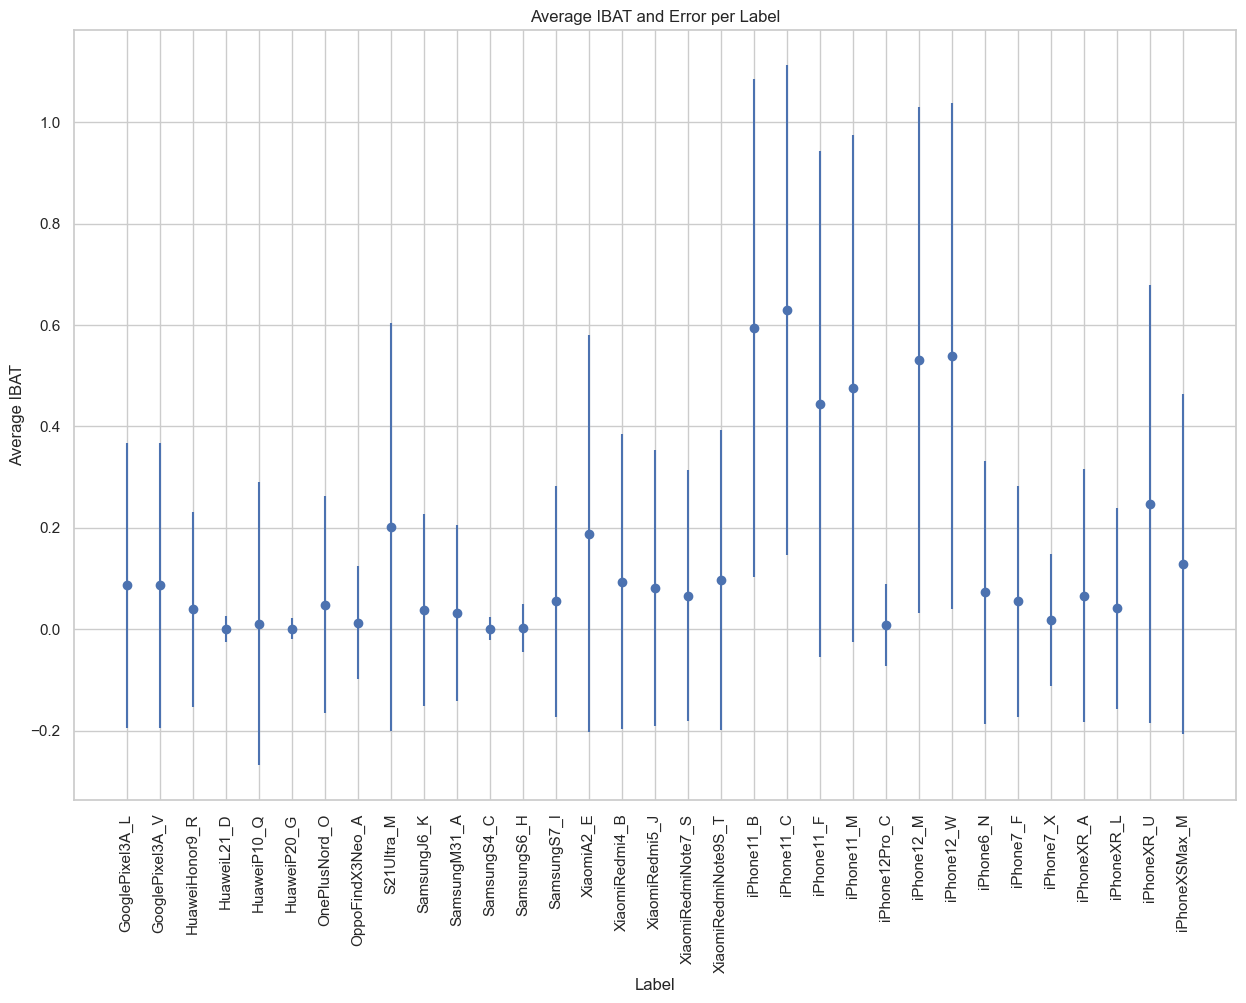

In [133]:
plotHelper.plot_average_and_error(combined_df, "Label", "IBAT")

## First Seen Channel Time

Interval time between the burst emission (0) and the first time a DS Channel is used.

In [134]:
# Sort by MAC Address and Timestamp
combined_df.sort_values(by=["MAC Address", "Timestamp"], inplace=True)

# Get the first timestamp for each MAC Address
first_timestamps = combined_df.groupby("MAC Address")["Timestamp"].first()


# Calculate intervals for the first occurrence of each DS Channel
def calculate_intervals(group):
    group["Interval"] = (
        group["Timestamp"] - first_timestamps[group.name]
    ).dt.total_seconds()
    return group.groupby("DS Channel").first()


# Apply the function to each MAC Address group and reset index
intervals = (
    combined_df.groupby("MAC Address")
    .apply(calculate_intervals)
    .reset_index(level="DS Channel")
)

# Pivot the data
fsct = intervals.pivot(index="MAC Address", columns="DS Channel", values="Interval")

# Rename columns to FSCT-1, FSCT-2, ..., FSCT-13 and reset index
fsct.columns = [f"FSCT-{int(col)}" for col in fsct.columns]

# Retrieve the Label column from the original data
labels = combined_df.drop_duplicates("MAC Address").set_index("MAC Address")["Label"]

# Join the FSCT data with the Label column
fsct = fsct.join(labels)

# Reset index to include MAC Address as a column
fsct.reset_index(inplace=True)

/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_1005/3158989813.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_intervals)


Dropping the column of empty `DS Channel`

In [135]:
fsct.drop(columns=["FSCT--1"], inplace=True)

In [136]:
# fsct.fillna(0, inplace=True)

Save FSCT dataset with MAC Addresses and Labels

In [137]:
fsct.to_csv(config["DEFAULT"]["interim_path"] + "combined_df_balanced_fsct.csv")

In [138]:
fsct

,MAC Address,FSCT-1,FSCT-2,FSCT-3,FSCT-4,FSCT-5,FSCT-6,FSCT-7,FSCT-8,FSCT-9,FSCT-10,FSCT-11,FSCT-12,FSCT-13,Label
0,00:0f:00:6a:68:8b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SamsungJ6_K
1,00:be:3b:a2:a8:56,0.000000,0.043550,0.090959,29.715403,0.178241,0.222561,0.267727,29.892387,0.355262,0.399559,0.444297,0.488570,0.533296,HuaweiP20_G
2,02:00:00:00:00:00,0.000000,0.112811,0.152743,0.265630,7251.903858,0.381197,4046.760916,0.534422,0.618308,0.763675,0.839614,0.915742,0.993008,SamsungM31_A
3,02:00:00:00:3e:b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,iPhone11_C
4,02:00:3a:5e:a1:f4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,iPhone11_B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,fe:f9:ac:47:0d:b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,iPhone12_W
4411,fe:f9:fc:fb:83:9e,0.337505,NaN,NaN,0.483576,0.505750,0.000000,0.043133,0.084950,0.126696,0.190064,0.211886,0.274438,0.296181,iPhone6_N
4412,fe:fc:07:34:10:69,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone11_C
4413,fe:fc:aa:d1:89:d1,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone12_W


/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/scripts/plotHelper.py:278: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/scripts/plotHelper.py:278: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/scripts/plotHelper.py:278: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/scripts/plotHelper.py:278: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale("log")
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repo

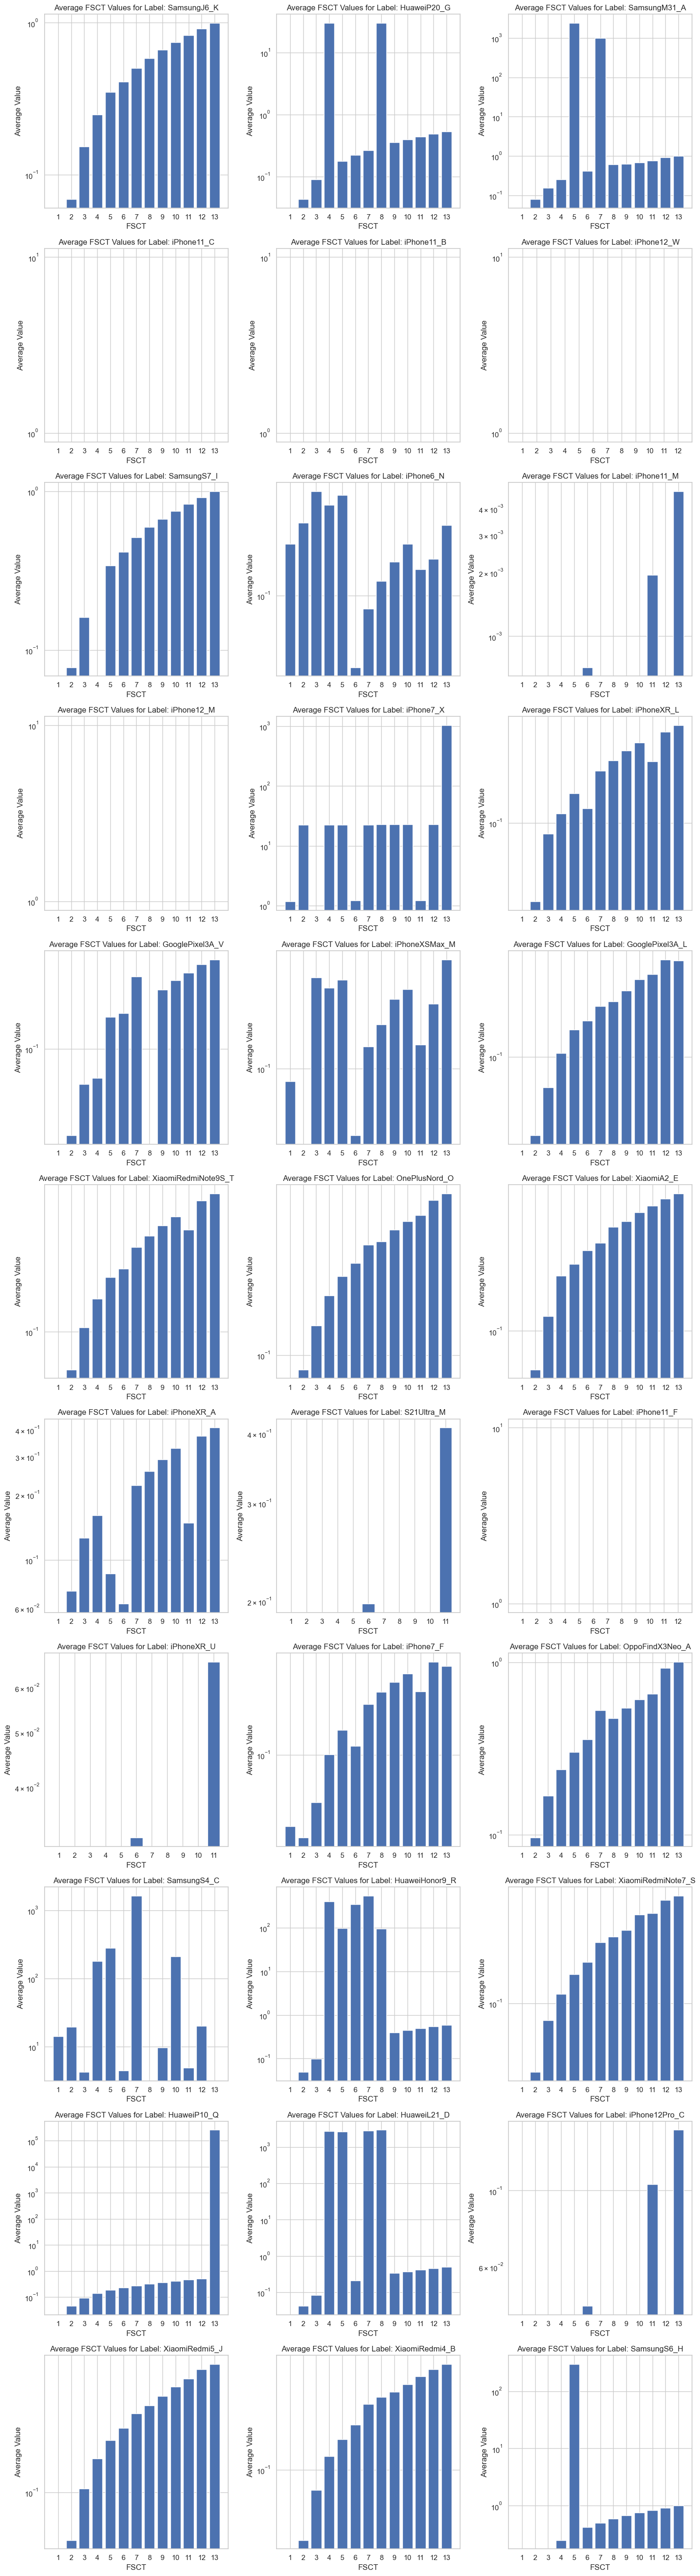

In [139]:
# Sample call to the function
plotHelper.plot_fsct_bar_by_label(fsct)

Average number of Probe Requests per device

In [140]:
# Average unique MAC Address per Label

# Get the unique MAC Addresses per Label
unique_mac_addresses = combined_df.drop_duplicates("MAC Address").groupby("Label")

# Calculate the average unique MAC Addresses per Label
unique_mac_addresses = unique_mac_addresses.count()["MAC Address"].mean()

print("Average unique MAC Addresses per Label:", unique_mac_addresses)

Average unique MAC Addresses per Label: 133.78787878787878


## Intra Burst Channel Switching Time

Time it takes for a burst (group of Probe Requests sharing a common MAC Address) to switch the channel. Average, Min, Max, Std.

Calculating Intra-Burst Channel Switching Time (IBCST) from previous calculations on single ds Channel switching

In [141]:
fsct["IBCST_avg"] = fsct.drop(columns=["MAC Address", "Label"]).mean(axis=1)

fsct["IBCST_max"] = fsct.drop(columns=["MAC Address", "Label"]).max(axis=1)

fsct["IBCST_std"] = fsct.drop(columns=["MAC Address", "Label"]).std(axis=1)

In [142]:
# Drop the FSCT columns
fsct.drop(columns=[col for col in fsct.columns if "FSCT" in col], inplace=True)

In [143]:
fsct

,MAC Address,Label,IBCST_avg,IBCST_max,IBCST_std
0,00:0f:00:6a:68:8b,SamsungJ6_K,NaN,NaN,NaN
1,00:be:3b:a2:a8:56,HuaweiP20_G,4.817832,29.892387,12.138480
2,02:00:00:00:00:00,SamsungM31_A,869.557071,7251.903858,2634.326034
3,02:00:00:00:3e:b2,iPhone11_C,0.000000,0.000000,0.000000
4,02:00:3a:5e:a1:f4,iPhone11_B,0.000000,0.000000,0.000000
...,...,...,...,...,...
4410,fe:f9:ac:47:0d:b7,iPhone12_W,0.000000,0.000000,0.000000
4411,fe:f9:fc:fb:83:9e,iPhone6_N,0.232198,0.505750,0.170471
4412,fe:fc:07:34:10:69,iPhone11_C,0.000000,0.000000,0.000000
4413,fe:fc:aa:d1:89:d1,iPhone12_W,0.000000,0.000000,0.000000


In [144]:
# Dimension of fsct
fsct.shape

(4415, 5)